# Low-Rank Gaussian Coefficients and Covariance Geometry

## Model

$$
x = W z + \varepsilon,\quad \Sigma = W W^\top + \sigma^2 I_d
$$

Coefficient changes are restricted to
$$
\Delta W = B A.
$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import slogdet, inv

rng = np.random.default_rng(1)

In [2]:
d = 40
k = 8
sigma = 0.1
n = 1500

W0 = rng.normal(size=(d, k))

In [3]:
def covariance(W):
    return W @ W.T + sigma**2 * np.eye(d)

def nll(S, W):
    Sigma = covariance(W)
    sign, logdet = slogdet(Sigma)
    return 0.5 * (logdet + np.trace(inv(Sigma) @ S))

In [4]:
rank_star = 2
B = rng.normal(size=(d, rank_star))
A = rng.normal(size=(rank_star, k))
DeltaW_lr = B @ A

D = rng.normal(size=(d, k))
DeltaW_dense = D / np.linalg.norm(D, 'fro') * np.linalg.norm(DeltaW_lr, 'fro')

def sample(W):
    z = rng.normal(size=(n, k))
    eps = sigma * rng.normal(size=(n, d))
    return z @ W.T + eps

S_lr = (sample(W0 + DeltaW_lr).T @ sample(W0 + DeltaW_lr)) / n
S_dense = (sample(W0 + DeltaW_dense).T @ sample(W0 + DeltaW_dense)) / n

## Rank Sweep

In [5]:
ranks = [0, 1, 2, 4, 8]
nll_lr = []
nll_dense = []

for r in ranks:
    if r == 0:
        W = W0
    else:
        B = rng.normal(size=(d, r))
        A = rng.normal(size=(r, k))
        W = W0 + B @ A

    nll_lr.append(nll(S_lr, W))
    nll_dense.append(nll(S_dense, W))

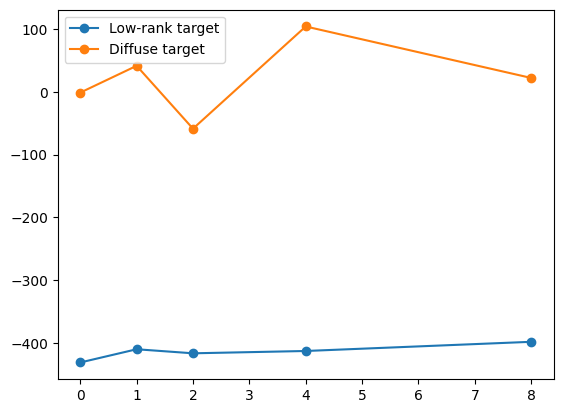

In [6]:
plt.plot(ranks, nll_lr, marker='o', label='Low-rank target')
plt.plot(ranks, nll_dense, marker='o', label='Diffuse target')
plt.legend()
plt.show()

In [7]:
# --- Eigenvalue analysis required by assignment ---

def eigvals_sorted(M):
    vals = np.linalg.eigvalsh(M)
    return np.sort(vals)[::-1]  

Sigma0 = covariance(W0)

eig0 = eigvals_sorted(Sigma0)
eig_lr = eigvals_sorted(S_lr)
eig_dense = eigvals_sorted(S_dense)

print("Top 5 eigenvalues Σ0:", eig0[:5])
print("Top 5 eigenvalues S_low-rank:", eig_lr[:5])
print("Top 5 eigenvalues S_diffuse:", eig_dense[:5])


Top 5 eigenvalues Σ0: [62.67754054 53.66580038 47.78180131 34.0302818  24.4941235 ]
Top 5 eigenvalues S_low-rank: [7.30377669 3.86939275 2.47717335 1.53020392 1.25901848]
Top 5 eigenvalues S_diffuse: [10.86769583  9.44841447  6.21739014  6.0552556   3.69093369]


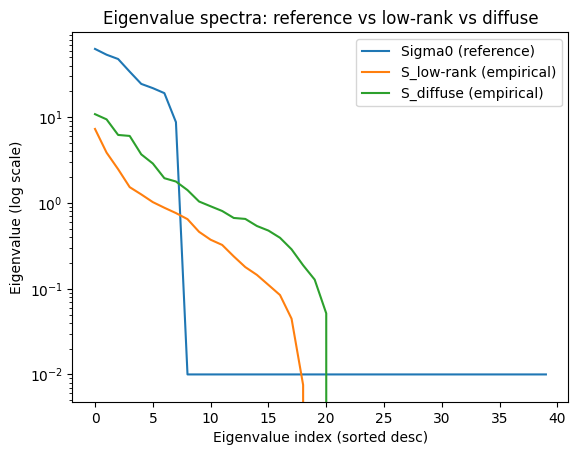

In [8]:
plt.figure()
plt.plot(eig0, label="Sigma0 (reference)")
plt.plot(eig_lr, label="S_low-rank (empirical)")
plt.plot(eig_dense, label="S_diffuse (empirical)")
plt.yscale("log")
plt.xlabel("Eigenvalue index (sorted desc)")
plt.ylabel("Eigenvalue (log scale)")
plt.legend()
plt.title("Eigenvalue spectra: reference vs low-rank vs diffuse")
plt.show()


In [9]:
threshold = 0.10 

rel_change_lr = np.abs(eig_lr - eig0) / (np.abs(eig0) + 1e-12)
rel_change_dense = np.abs(eig_dense - eig0) / (np.abs(eig0) + 1e-12)

num_sig_lr = int(np.sum(rel_change_lr > threshold))
num_sig_dense = int(np.sum(rel_change_dense > threshold))

print("Significantly changed eigenvalues (low-rank):", num_sig_lr)
print("Significantly changed eigenvalues (diffuse):", num_sig_dense)


Significantly changed eigenvalues (low-rank): 40
Significantly changed eigenvalues (diffuse): 40


1. Low-rank modification
In the low rank case, only a limited number of dominant eigenvalues are expected to change substantially because the coefficient pertubation has restricted rank. A rank-r modification can only alter variance along r geometric directions in the covariance structure. Therefore, the number of significatnly changed eigenvalues should relate directly to the rank of the perturbation which demonstrates that low rank updates will concentrate their effect in a small subsapce.

2. Diffuse modification
In the diffuse case, the perturbation is dense and approximately full rank. Even though its overall Froberius norm matches the low rank change, the variance is distributed across many directions instead of a few dominant ones. As a result, many eigenvalues shift, reflecting global changes to the covariance spectrum instead of localized directional variation. 

3. Rank and variance directions
These observations illustrate that matrix rank constrains the number of independent directions that can change in a Gaussian covariance matrix. Low rank perturbations modify only a small subset of wigenvalues corresponding to a low dimensional subspace, while full rank perturbations spread variance changes across the entire spectrum. As a result, eigenvalue behavior provides a direct geometric interpretation of rank with how many directions of variability are affected. 